# Initialisation

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
from numpy import ravel
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr

# TP1

# Ajout du Dataset

In [2]:
features = pd.read_csv('acsincome_ca_features.csv')

In [3]:
labels = pd.read_csv('acsincome_ca_labels.csv')


## Visualisation des données du dataset

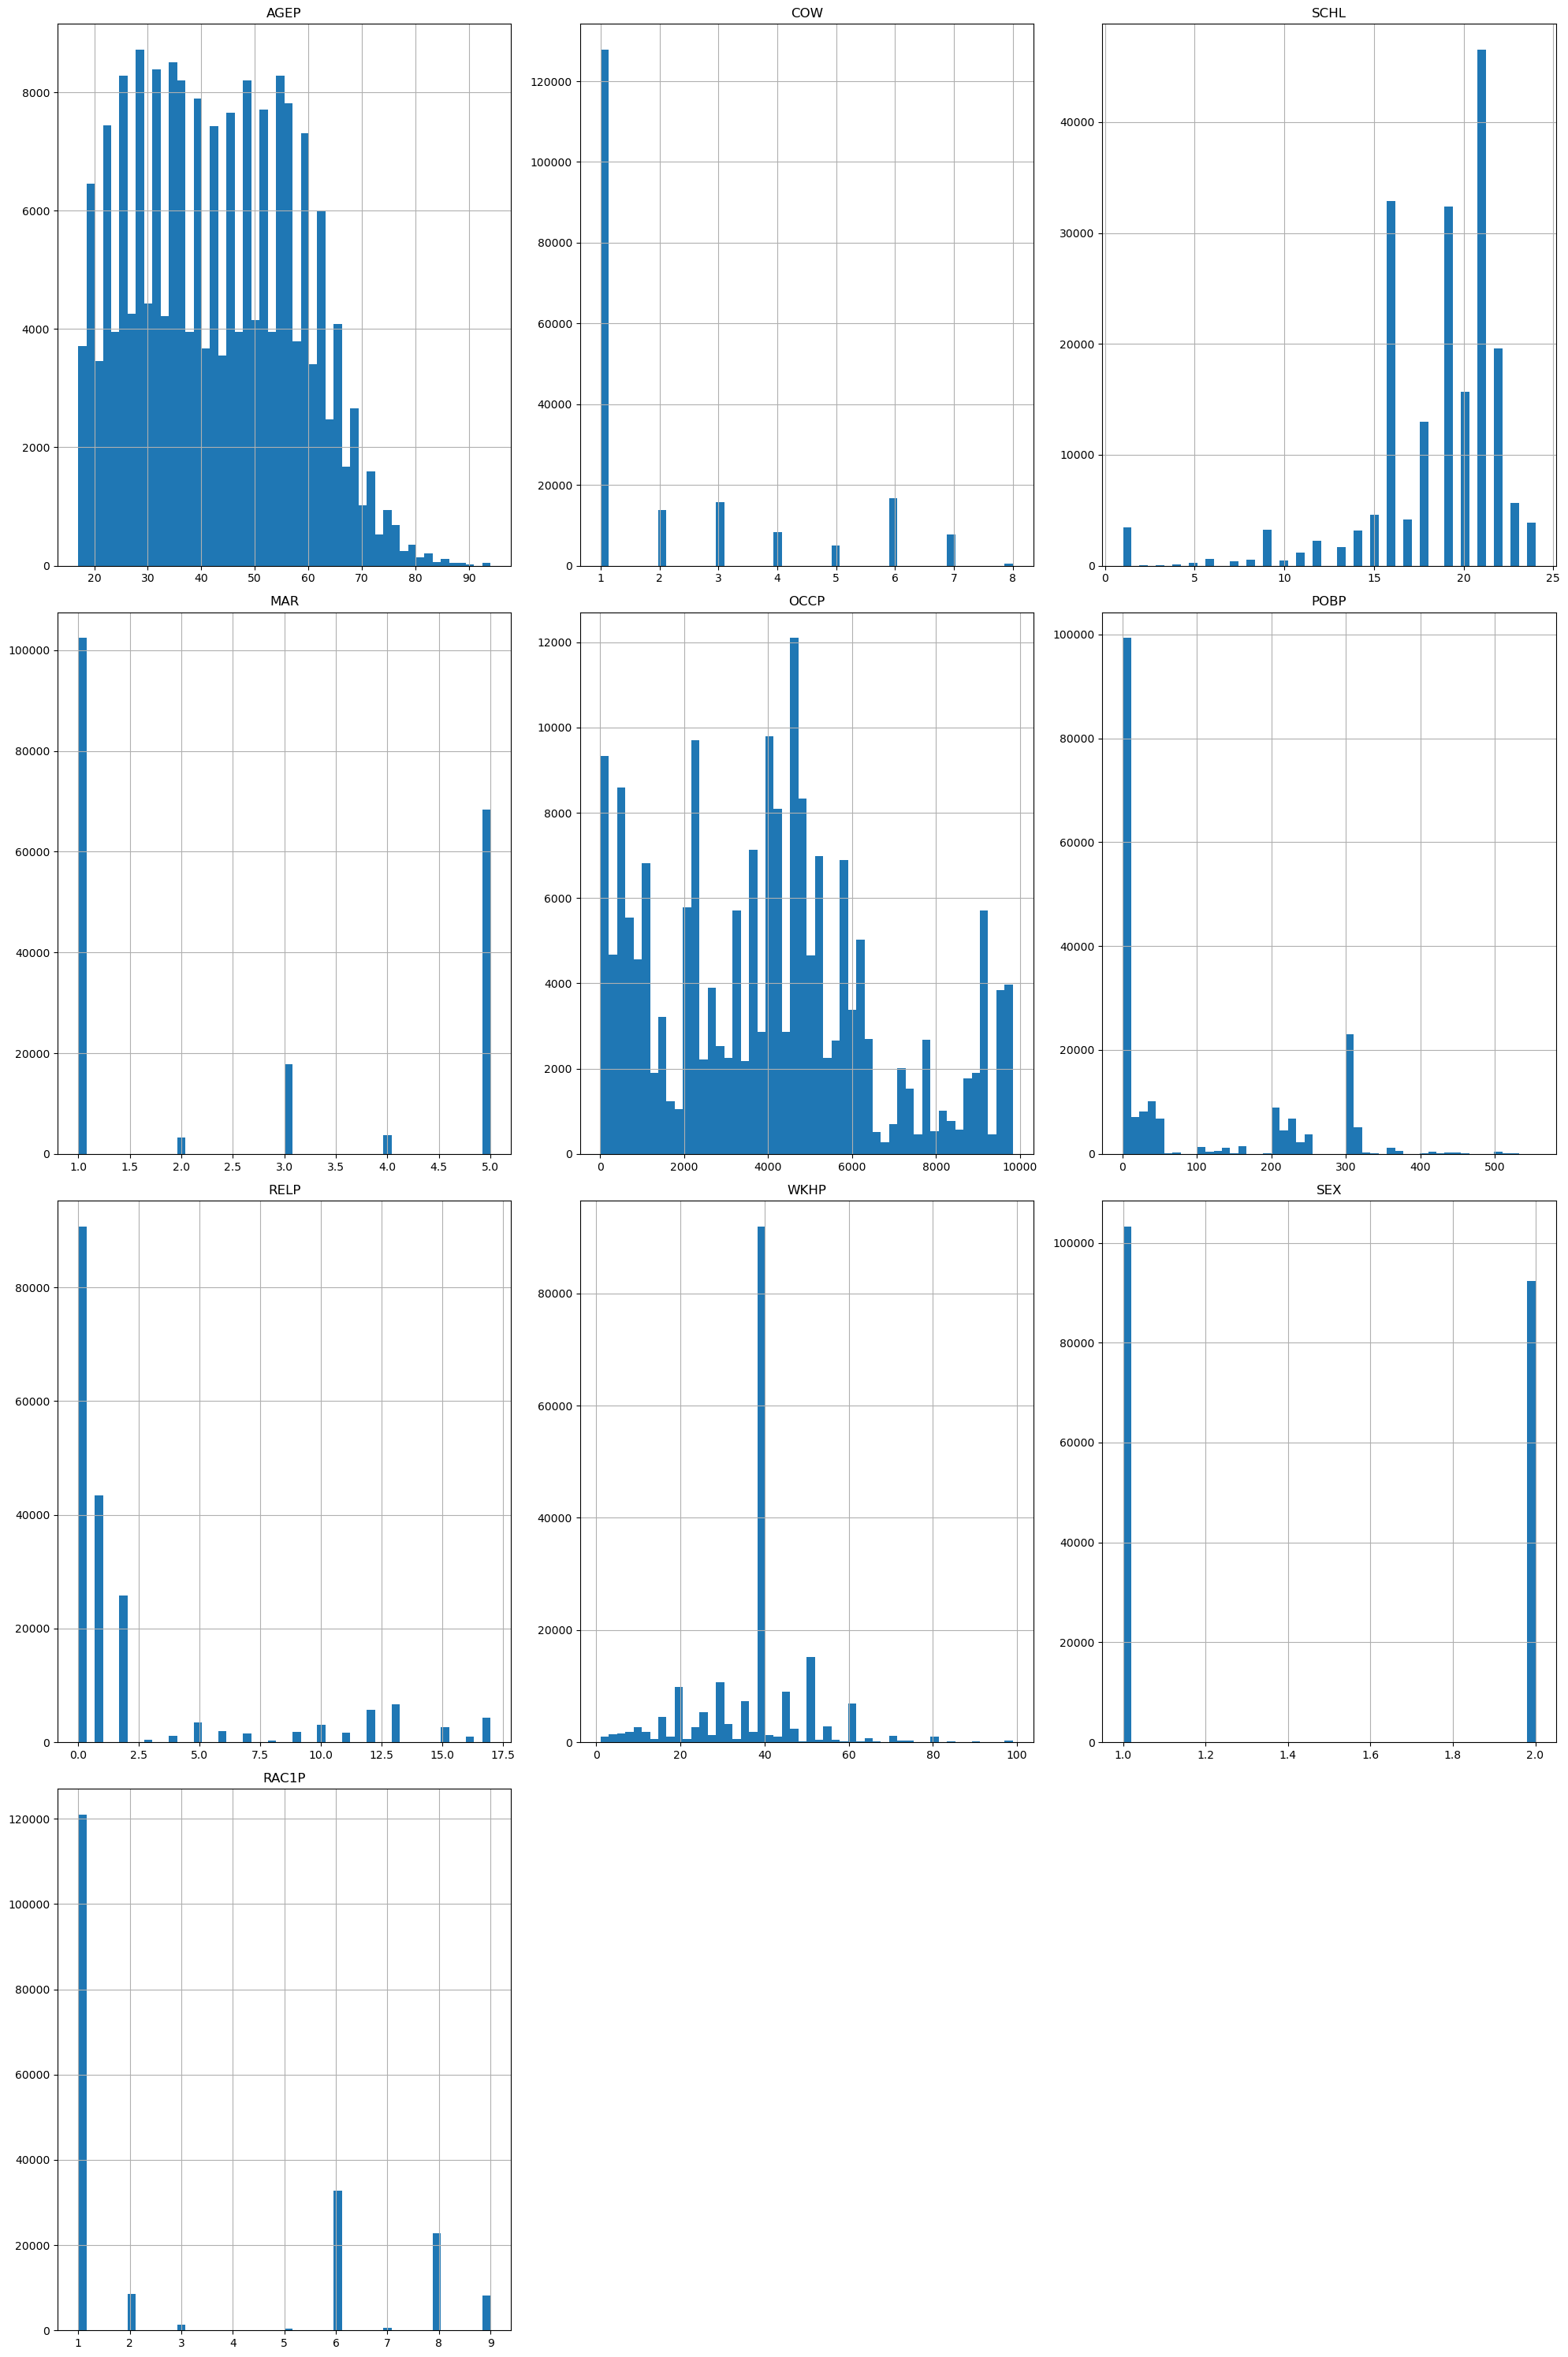

In [4]:
dataset = pd.concat([features, labels], axis=1)
dataset.hist(figsize=(20, 30), bins=50, grid=True)  
plt.tight_layout()
plt.show()

# Standardisation des données

In [5]:
scaler = StandardScaler()

fit_features = scaler.fit_transform(features)
fit_labels = scaler.fit_transform(labels)

# Shuffeling

In [6]:
# Mélange des indices
indices = shuffle(range(len(features)), random_state=1)

# On utilise les indices mélangés pour obtenir les nouvelles versions de X_all et y_all
X_all = features.iloc[indices]
y_all = labels.iloc[indices]

# On utilise seulement les premiers N échantillons pour limiter le temps d'entraînement 
num_samples = int(len(X_all) * 0.1)
X, y = X_all.iloc[:num_samples], y_all.iloc[:num_samples]

# Subdivising

In [7]:
# On divise les données en un ensemble d'entraînement (80%) et un ensemble de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# On affiche la taille des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))


Taille de l'ensemble d'entraînement : 15652
Taille de l'ensemble de test : 3914


# Cross Validation

In [20]:
# On crée une liste de modèles
models = [
    ("SVM", SVC()),
    ("Adaboost", AdaBoostClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("RandomForest", RandomForestClassifier())
]

# On boucle sur les modèles
for name, model in models:
    # On aplati la cible y_train
    y_train_flattened = ravel(y_train)
    # On effectue une cross-validation
    scores = cross_val_score(model, X_train, y_train_flattened, cv=5)
    print(f"{name}: Mean Accuracy: {scores.mean()}, Standard Deviation: {scores.std()}")
    

SVM: Mean Accuracy: 0.7009974867423876, Standard Deviation: 0.008393773338481389
Adaboost: Mean Accuracy: 0.8071812433227246, Standard Deviation: 0.01055795089617608
GradientBoosting: Mean Accuracy: 0.8101839280083837, Standard Deviation: 0.008656930433518005
RandomForest: Mean Accuracy: 0.8006004063252867, Standard Deviation: 0.008978867642254654


# Evaluation

In [94]:
for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model

    model_instance.fit(X_train, y_train_flattened)

   
    y_pred = model_instance.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Evaluation results for {name}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n" + "="*50 + "\n")  # Juste une séparation visuelle entre les résultats des différents modèles


Evaluation results for SVM:
Accuracy: 0.7077158916709249
Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.82      0.77      2326
        True       0.68      0.54      0.60      1588

    accuracy                           0.71      3914
   macro avg       0.70      0.68      0.68      3914
weighted avg       0.70      0.71      0.70      3914

Confusion Matrix:
 [[1917  409]
 [ 735  853]]


Evaluation results for Adaboost:
Accuracy: 0.8078691875319366
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.84      0.84      2326
        True       0.77      0.76      0.76      1588

    accuracy                           0.81      3914
   macro avg       0.80      0.80      0.80      3914
weighted avg       0.81      0.81      0.81      3914

Confusion Matrix:
 [[1963  363]
 [ 389 1199]]


Evaluation results for GradientBoosting:
Accuracy: 0.8117015840572305
Classificatio

## Recherche des hyperparamétres optimaux des différents modèles

**SVM** 
Nous avons testé tous les différents kernels disponibles. Cependant, les kernels Linear et Precomputed n'ont pas l'air de fonctionner.

In [10]:
# On définit les hyperparamètres qu'on souhaite rechercher pour chaque modèle
param_grid = {
    'SVM' :{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['rbf','poly','sigmoid']},
    'Adaboost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
}

# On boucle sur les modèles et on effectue la recherche des hyperparamètres
for name, model in models:
    if name in param_grid:
        y_train_flattened = ravel(y_train)
        grid_search = GridSearchCV(model, param_grid[name], cv=5)
        grid_search.fit(X_train, y_train_flattened)
        print(name)
        print(f"Best hyperparameters for {name}: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_}")
        print("\n")


SVM
Best hyperparameters for SVM: {'C': 1000, 'kernel': 'rbf'}
Best cross-validation score: 0.7672503859682063


Adaboost
Best hyperparameters for Adaboost: {'learning_rate': 1, 'n_estimators': 200}
Best cross-validation score: 0.814336445908839


GradientBoosting
Best hyperparameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validation score: 0.816061542668747


RandomForest
Best hyperparameters for RandomForest: {'max_depth': 10, 'n_estimators': 100}
Best cross-validation score: 0.8106949876684052




# Test sur les données

In [21]:
# On crée une liste de modèles
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

# On boucle sur les modèles
for name, model in models:
    y_train_flattened = ravel(y_train)
    # On effectue une cross-validation
    scores = cross_val_score(model, X_train, y_train_flattened, cv=5)
    print(f"{name}: Mean Accuracy: {scores.mean()}, Standard Deviation: {scores.std()}")

for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model

    model_instance.fit(X_train, y_train_flattened)


    y_pred = model_instance.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Evaluation results for {name}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n" + "="*50 + "\n")

SVM: Mean Accuracy: 0.7094308486810754, Standard Deviation: 0.008403597048301757
Adaboost: Mean Accuracy: 0.814336445908839, Standard Deviation: 0.009927827285828375
GradientBoosting: Mean Accuracy: 0.816061542668747, Standard Deviation: 0.008859359763865865
RandomForest: Mean Accuracy: 0.809608582830869, Standard Deviation: 0.01107431818526314
Evaluation results for SVM:
Accuracy: 0.7166581502299438
Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.82      0.77      2326
        True       0.68      0.56      0.62      1588

    accuracy                           0.72      3914
   macro avg       0.71      0.69      0.70      3914
weighted avg       0.71      0.72      0.71      3914

Confusion Matrix:
 [[1908  418]
 [ 691  897]]


Evaluation results for Adaboost:
Accuracy: 0.8140010219724068
Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.85      0.84      2326
  

    Faire shuffle puis echantillonage et puis enfin standardscaling

# Test des models sur d'autres datasets

In [22]:
nevada_features = pd.read_csv('./TP2_data/acsincome_ne_allfeaturesTP2.csv')
nevada_labels = pd.read_csv('./TP2_data/acsincome_ne_labelTP2.csv')

colorado_features = pd.read_csv('./TP2_data/acsincome_ne_allfeaturesTP2.csv')
colorado_labels =pd.read_csv('./TP2_data/acsincome_ne_labelTP2.csv')

In [23]:
# On mélange les indices
indices_co = shuffle(range(len(colorado_features)), random_state=1)
indices_ne = shuffle(range(len(nevada_features)), random_state=1)

# On utilise les indices mélangés pour obtenir les nouvelles versions de X_all et y_all
X_all_co = colorado_features.iloc[indices_co]
y_all_co = colorado_labels.iloc[indices_co]

X_all_ne = nevada_features.iloc[indices_ne]
y_all_ne = nevada_labels.iloc[indices_ne]

# only use the first N samples to limit training time
num_samples_co = int(len(X_all_co) * 0.01)
num_samples_ne = int(len(X_all_ne) * 0.01)
X_co, y_co = X_all_co.iloc[:num_samples_co], y_all_co.iloc[:num_samples_co]
X_ne, y_ne = X_all_ne.iloc[:num_samples_ne], y_all_ne.iloc[:num_samples_ne]

## Nevada

In [24]:
models = [
    ("SVM", SVC(C = 1000, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

for name, model in models:
    y_train_flattened = ravel(y_train)
    model.fit(X_train, y_train_flattened)
    
    y_pred = model.predict(X_ne)


    accuracy = accuracy_score(y_ne, y_pred)
    report = classification_report(y_ne, y_pred)
    conf_matrix = confusion_matrix(y_ne, y_pred)

    print(f"Evaluation results for {name}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n" + "="*50 + "\n")

Evaluation results for SVM:
Accuracy: 0.7383177570093458
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.78        64
           1       0.68      0.65      0.67        43

    accuracy                           0.74       107
   macro avg       0.73      0.72      0.73       107
weighted avg       0.74      0.74      0.74       107

Confusion Matrix:
 [[51 13]
 [15 28]]


Evaluation results for Adaboost:
Accuracy: 0.7289719626168224
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75        64
           1       0.63      0.79      0.70        43

    accuracy                           0.73       107
   macro avg       0.73      0.74      0.73       107
weighted avg       0.75      0.73      0.73       107

Confusion Matrix:
 [[44 20]
 [ 9 34]]


Evaluation results for GradientBoosting:
Accuracy: 0.7570093457943925
Classification Report:
      

## Colorado

In [25]:
models = [
    ("SVM", SVC(C = 1000, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

for name, model in models:
    y_train_flattened = ravel(y_train)
    model.fit(X_train, y_train_flattened)
    
    y_pred = model.predict(X_co)


    accuracy = accuracy_score(y_co, y_pred)
    report = classification_report(y_co, y_pred)
    conf_matrix = confusion_matrix(y_co, y_pred)

    print(f"Evaluation results for {name}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    print("\n" + "="*50 + "\n")

Evaluation results for SVM:
Accuracy: 0.7383177570093458
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.78        64
           1       0.68      0.65      0.67        43

    accuracy                           0.74       107
   macro avg       0.73      0.72      0.73       107
weighted avg       0.74      0.74      0.74       107

Confusion Matrix:
 [[51 13]
 [15 28]]


Evaluation results for Adaboost:
Accuracy: 0.7289719626168224
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75        64
           1       0.63      0.79      0.70        43

    accuracy                           0.73       107
   macro avg       0.73      0.74      0.73       107
weighted avg       0.75      0.73      0.73       107

Confusion Matrix:
 [[44 20]
 [ 9 34]]


Evaluation results for GradientBoosting:
Accuracy: 0.7570093457943925
Classification Report:
      

# -----------------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------------

# TP2

# Calcul de correlation 

In [99]:
noms_features = features.columns.tolist()
corr_coef = []
for feat in noms_features:
    correlation_coefficient = pearsonr(X_train[feat], y_train)
    corr_coef.append(correlation_coefficient[0][0])
    print(feat + " : " + str(correlation_coefficient[0][0]))

AGEP : 0.2625629832904517
COW : 0.05661628512750293
SCHL : 0.33965610681309416
MAR : -0.2866702542897235
OCCP : -0.34049768774736
POBP : -0.08322858734338258
RELP : -0.23075703768928618
WKHP : 0.3392247594394883
SEX : -0.11965047403799021
RAC1P : -0.10601229794741156


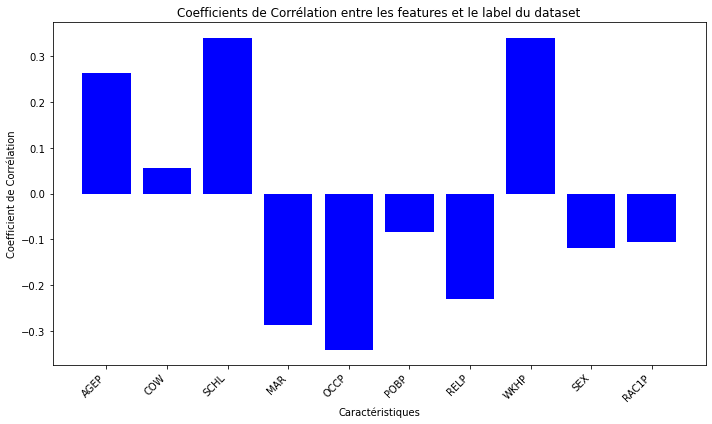

In [100]:
# Créer l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(noms_features, corr_coef, color='blue')
plt.xlabel('Caractéristiques')
plt.ylabel('Coefficient de Corrélation')
plt.title('Coefficients de Corrélation entre les features et le label du dataset')
plt.xticks(rotation=45, ha='right')  # Pour faire pivoter les noms des caractéristiques
plt.tight_layout()

# Afficher l'histogramme
plt.show()

In [18]:
# Créer une liste de modèles
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model
    model_instance.fit(X_train, y_train_flattened)
    if name == "SVM":
        y_pred_SVM = model_instance.predict(X_train)
    if name == "Adaboost":
        y_pred_Adaboost = model_instance.predict(X_train)
    if name == "GradientBoosting":
        y_pred_GradientBoosting = model_instance.predict(X_train)
    if name == "RandomForest":
        y_pred_RandomForest = model_instance.predict(X_train)

In [20]:
from scipy.stats import pearsonr

noms_features = features.columns.tolist()
y_list = [y_pred_SVM, y_pred_Adaboost, y_pred_GradientBoosting, y_pred_RandomForest]
n = 0
SVM_corr = []
Adaboost_corr = []
GradientBoosting_corr = []
RandomForest_corr = []

for y in y_list:
    for feat in noms_features:
        correlation_coefficient, _ = pearsonr(X_train[feat], y)  
        print(feat + " : " + str(correlation_coefficient))
        if n == 0:
            SVM_corr.append(correlation_coefficient)
        if n == 1:
            Adaboost_corr.append(correlation_coefficient)
        if n == 2:
            GradientBoosting_corr.append(correlation_coefficient)
        if n == 3:
            RandomForest_corr.append(correlation_coefficient)
    print("\n")
    n += 1

Model_corr = [SVM_corr, Adaboost_corr, GradientBoosting_corr, RandomForest_corr]


AGEP : 0.13564474688821815
COW : 0.07529920425985699
SCHL : 0.37157062795748796
MAR : -0.14949737613690198
OCCP : -0.775886655252237
POBP : -0.11062258014675827
RELP : -0.1351727961118739
WKHP : 0.1991096899167492
SEX : -0.0223246600277574
RAC1P : -0.10012903706682921


AGEP : 0.28928251896883206
COW : 0.06872310165237497
SCHL : 0.4406484881133683
MAR : -0.32838287855446474
OCCP : -0.4510864817345711
POBP : -0.12435668242829553
RELP : -0.2750096518105678
WKHP : 0.4092662296128794
SEX : -0.1527201550965624
RAC1P : -0.1345652772406723


AGEP : 0.29192169332088447
COW : 0.08014621878636022
SCHL : 0.44698273308882136
MAR : -0.32787451043253024
OCCP : -0.4626219927929208
POBP : -0.12348228602682668
RELP : -0.282383744485745
WKHP : 0.4078774695724088
SEX : -0.1359387248037997
RAC1P : -0.1408088513180913


AGEP : 0.27318696687917005
COW : 0.0995178188328621
SCHL : 0.4541044361152409
MAR : -0.3224779676193174
OCCP : -0.4758279159082894
POBP : -0.12178215176565244
RELP : -0.27316073520666506
WK

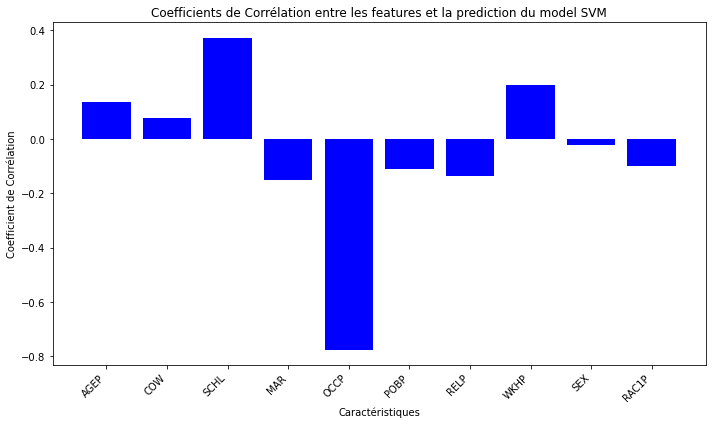

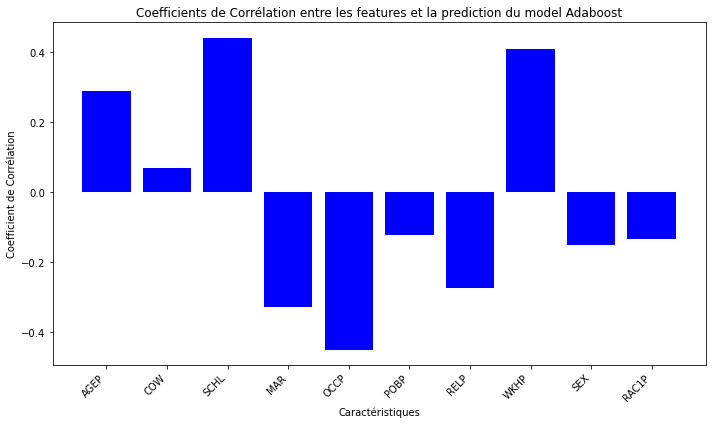

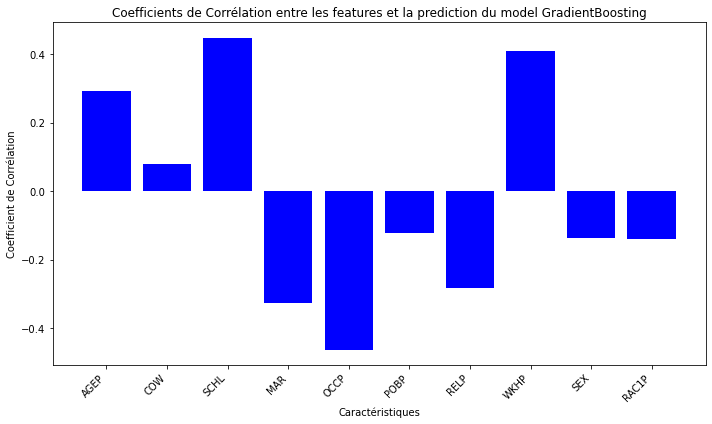

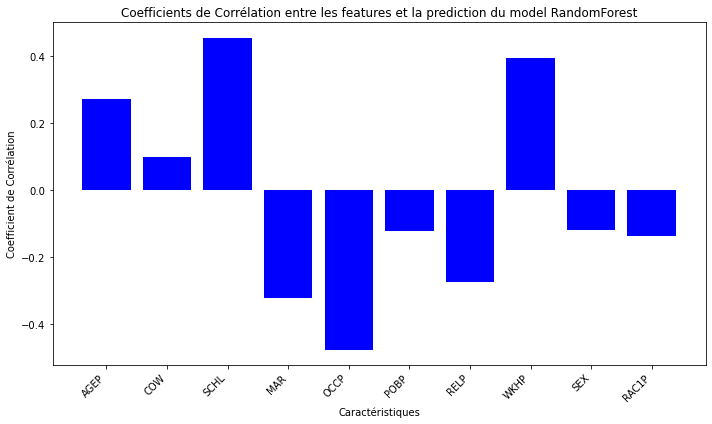

In [21]:
n = 0
for name, model in models:
    # Créer l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(noms_features, Model_corr[n], color='blue')
    plt.xlabel('Caractéristiques')
    plt.ylabel('Coefficient de Corrélation')
    plt.title('Coefficients de Corrélation entre les features et la prediction du model ' + name )
    plt.xticks(rotation=45, ha='right')  # Pour faire pivoter les noms des caractéristiques
    plt.tight_layout()

    # Afficher l'histogramme
    plt.show()
    n += 1

In [22]:
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]

for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model
    model_instance.fit(X_train, y_train_flattened)
    if name == "SVM":
        result_SVM = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    if name == "Adaboost":
        result_Adaboost = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    if name == "GradientBoosting":
        result_GradientBoosting = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    if name == "RandomForest":
        result_RandomForest = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

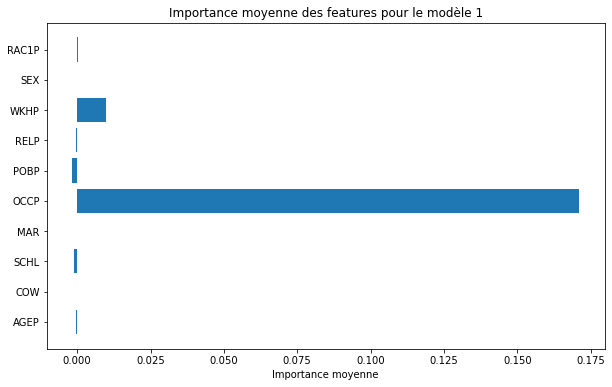

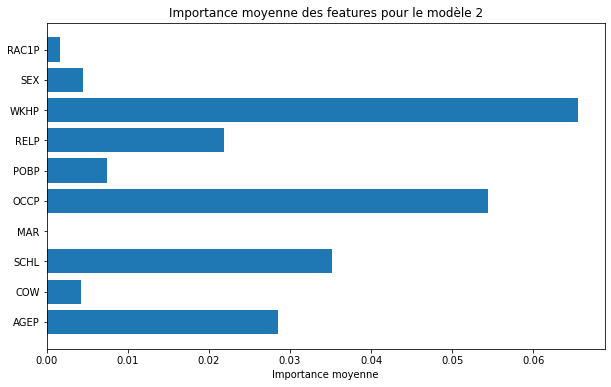

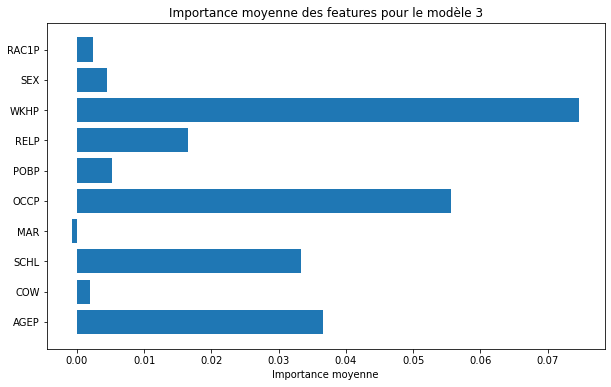

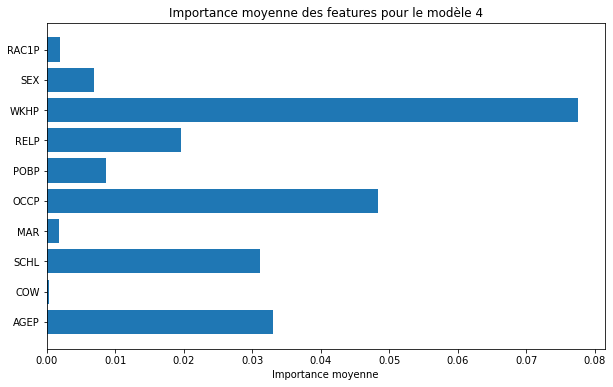

In [23]:
result_list = [result_SVM, result_Adaboost, result_GradientBoosting, result_RandomForest]
result_list[0]['importances_mean']

feature_names = features.columns
for idx, result in enumerate(result_list):
    importance_means = result['importances_mean']

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance_means)), importance_means, align='center')
    plt.yticks(range(len(importance_means)), feature_names)
    plt.xlabel('Importance moyenne')
    plt.title(f'Importance moyenne des features pour le modèle {idx + 1}')
    plt.show()

# Matrice de confusion de la feature 'SEX' pour les différents modèles

In [101]:
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=  200))
]
feature = 'SEX'

diff_valeur = features[feature].unique()

True_positive = {}
True_negative = {}
False_positive = {}
False_negative = {}


for name, model in models:
    for i in diff_valeur:
        y_train_flattened = ravel(y_train)
        model_instance = model
        model_instance.fit(X_train, y_train_flattened)
        
        y_pred = model_instance.predict(X_test)
        mask = (X_test[feature] == i)
        conf_matrix = confusion_matrix(y_test[mask], y_pred[mask])
        tn, fp, fn, tp = conf_matrix.ravel()
        key = f"{i}_{name}"
        True_positive[key] = tp
        True_negative[key] = tn
        False_positive[key] = fp
        False_negative[key] = fn
        
        
        # print(f"Confusion matrix for {feature} using {name} for value of {int(i)}:")
        # print(conf_matrix)
        # print("\n" + "="*50 + "\n")

print("TP : ")
print(True_positive)
print("TN : ")
print(True_negative)
print("FP : ")
print(False_positive)
print("FN : ")
print(False_negative)

#Taux de True positive et de True negative
Taux_TP = {}
Taux_TN = {}
for k in True_positive.keys():
    Taux_TP[k] = True_positive[k]/(True_positive[k]+False_negative[k])
    Taux_TN[k] = True_negative[k]/(True_negative[k]+False_positive[k])


print("\n")

print("Sensibilité : ")
print(Taux_TP)
print("Spécificité : ")
print(Taux_TN)


TP : 
{'1.0_SVM': 509, '2.0_SVM': 388, '1.0_Adaboost': 742, '2.0_Adaboost': 469, '1.0_GradientBoosting': 734, '2.0_GradientBoosting': 480, '1.0_RandomForest': 710, '2.0_RandomForest': 483}
TN : 
{'1.0_SVM': 944, '2.0_SVM': 964, '1.0_Adaboost': 915, '2.0_Adaboost': 1060, '1.0_GradientBoosting': 923, '2.0_GradientBoosting': 1054, '1.0_RandomForest': 929, '2.0_RandomForest': 1045}
FP : 
{'1.0_SVM': 180, '2.0_SVM': 238, '1.0_Adaboost': 209, '2.0_Adaboost': 142, '1.0_GradientBoosting': 201, '2.0_GradientBoosting': 148, '1.0_RandomForest': 195, '2.0_RandomForest': 157}
FN : 
{'1.0_SVM': 410, '2.0_SVM': 281, '1.0_Adaboost': 177, '2.0_Adaboost': 200, '1.0_GradientBoosting': 185, '2.0_GradientBoosting': 189, '1.0_RandomForest': 209, '2.0_RandomForest': 186}


Sensibilité : 
{'1.0_SVM': 0.5538628944504896, '2.0_SVM': 0.5799701046337817, '1.0_Adaboost': 0.8073993471164309, '2.0_Adaboost': 0.7010463378176383, '1.0_GradientBoosting': 0.7986942328618063, '2.0_GradientBoosting': 0.7174887892376681, '

## Retirer la colonne 'SEX' du dataset

In [102]:
X_train_no_sex = X_train.drop("SEX", axis=1)
X_test_no_sex = X_test.drop("SEX", axis=1)


## Matrice de confusion avec des modèles entraînés avec un dataset sans la colonne 'SEX'

### On recalcule également les True_positive, True_negative, False_positive et False_negative

In [103]:
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators= 200))
]

True_positive = {}
True_negative = {}
False_positive = {}
False_negative = {}

for name, model in models:
    y_train_flattened = ravel(y_train)
    model_instance = model
    model_instance.fit(X_train_no_sex, y_train_flattened)
    
    y_pred = model_instance.predict(X_test_no_sex)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    key = name
    True_positive[key] = tp
    True_negative[key] = tn
    False_positive[key] = fp
    False_negative[key] = fn

print("TP : ")
print(True_positive)
print("TN : ")
print(True_negative)
print("FP : ")
print(False_positive)
print("FN : ")
print(False_negative)

#Taux de True positive et de True negative
Taux_TP = {}
Taux_TN = {}
for k in True_positive.keys():
    Taux_TP[k] = True_positive[k]/(True_positive[k]+False_negative[k])
    Taux_TN[k] = True_negative[k]/(True_negative[k]+False_positive[k])

print("\n")

print("Sensibilité : ")
print(Taux_TP)
print("Spécificité : ")
print(Taux_TN)


TP : 
{'SVM': 897, 'Adaboost': 1208, 'GradientBoosting': 1212, 'RandomForest': 1186}
TN : 
{'SVM': 1908, 'Adaboost': 1979, 'GradientBoosting': 1975, 'RandomForest': 1962}
FP : 
{'SVM': 418, 'Adaboost': 347, 'GradientBoosting': 351, 'RandomForest': 364}
FN : 
{'SVM': 691, 'Adaboost': 380, 'GradientBoosting': 376, 'RandomForest': 402}


Sensibilité : 
{'SVM': 0.5648614609571788, 'Adaboost': 0.760705289672544, 'GradientBoosting': 0.7632241813602015, 'RandomForest': 0.7468513853904282}
Spécificité : 
{'SVM': 0.820292347377472, 'Adaboost': 0.850816852966466, 'GradientBoosting': 0.8490971625107481, 'RandomForest': 0.8435081685296647}


## On caclule les matrices de confusion en fonction de la feature SEX du dataset,"male" or "female") en train et en test en gardant cette feature SEX


In [119]:
sex_dict = {1: 'male', 2: 'female'}

for name, model in models:
    for sex_value in [1, 2]:
        y_train_flattened = ravel(y_train)
        model_instance = model
        model_instance.fit(X_train, y_train_flattened)
        y_pred_test_with_sex = model_instance.predict(X_test)
        mask = (X_test["SEX"] == sex_value)
        if mask.any():  
            conf_matrix = confusion_matrix(y_test[mask], y_pred_test_with_sex[mask])
            tn, fp, fn, tp = conf_matrix.ravel()
            key = f"{sex_dict[sex_value]}_{name}"
            True_positive[key] = tp
            True_negative[key] = tn
            False_positive[key] = fp
            False_negative[key] = fn


            # print(f"Confusion matrix for {feature} using {name} for value of {int(i)}:")
            # print(conf_matrix)
            # print("\n" + "="*50 + "\n")

   
        else:
            print(f"No rows for {sex_dict[sex_value]} using {name}")
    print("TP : ")
    print(True_positive)
    print("TN : ")
    print(True_negative)
    print("FP : ")
    print(False_positive)
    print("FN : ")
    print(False_negative)

    #Taux de True positive et de True negative
    Taux_TP = {}
    Taux_TN = {}
    for k in True_positive.keys():
        Taux_TP[k] = True_positive[k]/(True_positive[k]+False_negative[k])
        Taux_TN[k] = True_negative[k]/(True_negative[k]+False_positive[k])


    print("\n")

    print("Sensibilité : ")
    print(Taux_TP)
    print("Spécificité : ")
    print(Taux_TN)

TP : 
{'SVM': 897, 'Adaboost': 1208, 'GradientBoosting': 1212, 'RandomForest': 1186, '2.0_SVM': 388, '2.0_Adaboost': 469, '2.0_GradientBoosting': 480, '2.0_RandomForest': 480, 'male_SVM': 509, 'female_SVM': 388, 'male_Adaboost': 742, 'female_Adaboost': 469, 'male_GradientBoosting': 734, 'female_GradientBoosting': 480, 'male_RandomForest': 709, 'female_RandomForest': 484}
TN : 
{'SVM': 1908, 'Adaboost': 1979, 'GradientBoosting': 1975, 'RandomForest': 1962, '2.0_SVM': 964, '2.0_Adaboost': 1060, '2.0_GradientBoosting': 1054, '2.0_RandomForest': 1048, 'male_SVM': 944, 'female_SVM': 964, 'male_Adaboost': 915, 'female_Adaboost': 1060, 'male_GradientBoosting': 923, 'female_GradientBoosting': 1054, 'male_RandomForest': 932, 'female_RandomForest': 1046}
FP : 
{'SVM': 418, 'Adaboost': 347, 'GradientBoosting': 351, 'RandomForest': 364, '2.0_SVM': 238, '2.0_Adaboost': 142, '2.0_GradientBoosting': 148, '2.0_RandomForest': 154, 'male_SVM': 180, 'female_SVM': 238, 'male_Adaboost': 209, 'female_Adaboo

TP : 
{'SVM': 897, 'Adaboost': 1208, 'GradientBoosting': 1212, 'RandomForest': 1186, '2.0_SVM': 388, '2.0_Adaboost': 469, '2.0_GradientBoosting': 480, '2.0_RandomForest': 480, 'male_SVM': 509, 'female_SVM': 388, 'male_Adaboost': 742, 'female_Adaboost': 469, 'male_GradientBoosting': 734, 'female_GradientBoosting': 480, 'male_RandomForest': 707, 'female_RandomForest': 479}
TN : 
{'SVM': 1908, 'Adaboost': 1979, 'GradientBoosting': 1975, 'RandomForest': 1962, '2.0_SVM': 964, '2.0_Adaboost': 1060, '2.0_GradientBoosting': 1054, '2.0_RandomForest': 1048, 'male_SVM': 944, 'female_SVM': 964, 'male_Adaboost': 915, 'female_Adaboost': 1060, 'male_GradientBoosting': 923, 'female_GradientBoosting': 1054, 'male_RandomForest': 929, 'female_RandomForest': 1047}
FP : 
{'SVM': 418, 'Adaboost': 347, 'GradientBoosting': 351, 'RandomForest': 364, '2.0_SVM': 238, '2.0_Adaboost': 142, '2.0_GradientBoosting': 148, '2.0_RandomForest': 154, 'male_SVM': 180, 'female_SVM': 238, 'male_Adaboost': 209, 'female_Adaboo

## Matrice de confusion de la feature 'RAC1P' pour les différents modèles

In [9]:
models = [
    ("SVM", SVC(C=10.0, kernel='rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate=1, n_estimators=200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators=200))
]
feature = 'RAC1P'

diff_values = [1,2,3,6,7,8,9]

True_positive_Race = {}
True_negative_Race = {}
False_positive_Race = {}
False_negative_Race = {}


for name, model in models:
    for value in diff_values:
        y_train_flattened = ravel(y_train)
        model_instance = model
        model_instance.fit(X_train, y_train_flattened)
        
        y_pred = model_instance.predict(X_test)
        mask = (X_test[feature] == value)
        conf_matrix = confusion_matrix(y_test[mask], y_pred[mask])
        tn_R, fp_R, fn_R, tp_R = conf_matrix.ravel()
        key = f"{value}_{name}"
        True_positive_Race[key] = tp_R
        True_negative_Race[key] = tn_R
        False_positive_Race[key] = fp_R
        False_negative_Race[key] = fn_R
        # print(f"Confusion matrix for {feature} using {name} for value of {value}:")
        # print(conf_matrix)
        # print("\n" + "="*50 + "\n")

print("TP : ")
print(True_positive_Race)
print("TN : ")
print(True_negative_Race)
print("FP : ")
print(False_positive_Race)
print("FN : ")
print(False_negative_Race)

#Taux de True positive et de True negative
Taux_TP_Race = {}
Taux_TN_Race = {}
for k in True_positive_Race.keys():
    Taux_TP_Race[k] = True_positive_Race[k]/(True_positive_Race[k]+False_negative_Race[k])
    Taux_TN_Race[k] = True_negative_Race[k]/(True_negative_Race[k]+False_positive_Race[k])


print("\n")

print("Sensibilité : ")
print(Taux_TP_Race)
print("Spécificité : ")
print(Taux_TN_Race)

TP : 
{'1_SVM': 596, '2_SVM': 33, '3_SVM': 2, '6_SVM': 200, '7_SVM': 3, '8_SVM': 23, '9_SVM': 40, '1_Adaboost': 818, '2_Adaboost': 44, '3_Adaboost': 3, '6_Adaboost': 250, '7_Adaboost': 4, '8_Adaboost': 38, '9_Adaboost': 54, '1_GradientBoosting': 825, '2_GradientBoosting': 41, '3_GradientBoosting': 4, '6_GradientBoosting': 249, '7_GradientBoosting': 4, '8_GradientBoosting': 39, '9_GradientBoosting': 52, '1_RandomForest': 798, '2_RandomForest': 41, '3_RandomForest': 5, '6_RandomForest': 247, '7_RandomForest': 4, '8_RandomForest': 32, '9_RandomForest': 53}
TN : 
{'1_SVM': 1117, '2_SVM': 98, '3_SVM': 19, '6_SVM': 260, '7_SVM': 13, '8_SVM': 307, '9_SVM': 83, '1_Adaboost': 1135, '2_Adaboost': 111, '3_Adaboost': 18, '6_Adaboost': 263, '7_Adaboost': 13, '8_Adaboost': 331, '9_Adaboost': 92, '1_GradientBoosting': 1141, '2_GradientBoosting': 109, '3_GradientBoosting': 19, '6_GradientBoosting': 261, '7_GradientBoosting': 14, '8_GradientBoosting': 328, '9_GradientBoosting': 93, '1_RandomForest': 11

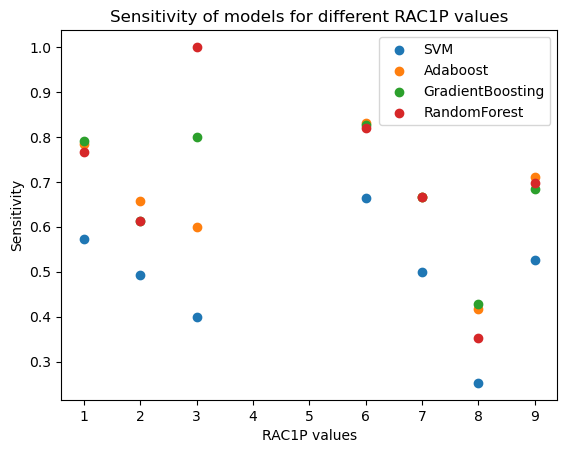

In [10]:
rac1p_values = diff_values

for model_name,_ in models:
    
    sensitivity_values = []
    
    
    for value in rac1p_values:
    
        key = f"{value}_{model_name}"
        if key in Taux_TP_Race:
            sensitivity_values.append(Taux_TP_Race[key])
        else:
            sensitivity_values.append(None)
    

    plt.scatter(rac1p_values, sensitivity_values, label=model_name)


plt.legend()
plt.xlabel('RAC1P values')
plt.ylabel('Sensitivity')
plt.title('Sensitivity of models for different RAC1P values')


plt.show()


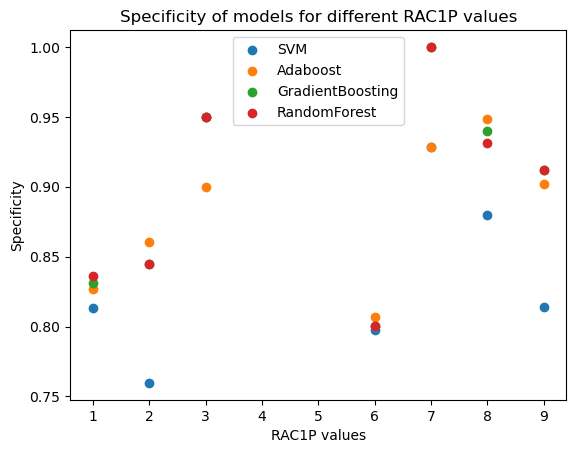

In [11]:

rac1p_values = diff_values


for model_name, _ in models:

    specificity_values = []
    

    for value in rac1p_values:

        key = f"{value}_{model_name}"
        if key in Taux_TN_Race:
            specificity_values.append(Taux_TN_Race[key])
        else:
            specificity_values.append(None)
    

    plt.scatter(rac1p_values, specificity_values, label=model_name)


plt.legend()
plt.xlabel('RAC1P values')
plt.ylabel('Specificity')
plt.title('Specificity of models for different RAC1P values')


plt.show()

## On retire la colonne 'RAC1P'

In [12]:
X_train_no_rac1p = X_train.drop("RAC1P", axis=1)
X_test_no_rac1p = X_test.drop("RAC1P", axis=1)

## Matrice de confusion avec des modèles entraînés avec un dataset sans la colonne 'RAC1P'

### On recalcule également les True_positive, True_negative, False_positive et False_negative

In [13]:
models = [
    ("SVM", SVC(C = 10.0, kernel = 'rbf')),
    ("Adaboost", AdaBoostClassifier(learning_rate = 1, n_estimators = 200)),
    ("GradientBoosting", GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)),
    ("RandomForest", RandomForestClassifier(max_depth=10, n_estimators= 200))
]

diff_values = [1,2,3,6,7,8,9]

True_positive_Race = {}
True_negative_Race = {}
False_positive_Race = {}
False_negative_Race = {}


for name, model in models:
    for value in diff_values:
        y_train_flattened = ravel(y_train)
        model_instance = model
        model_instance.fit(X_train_no_rac1p, y_train_flattened)
        
        y_pred = model_instance.predict(X_test_no_rac1p)
        mask = (X_test[feature] == value)
        conf_matrix = confusion_matrix(y_test[mask], y_pred[mask])
        tn_R, fp_R, fn_R, tp_R = conf_matrix.ravel()
        key = f"{value}_{name}"
        True_positive_Race[key] = tp_R
        True_negative_Race[key] = tn_R
        False_positive_Race[key] = fp_R
        False_negative_Race[key] = fn_R
        # print(f"Confusion matrix for {feature} using {name} for value of {value}:")
        # print(conf_matrix)
        # print("\n" + "="*50 + "\n")

print("TP : ")
print(True_positive_Race)
print("TN : ")
print(True_negative_Race)
print("FP : ")
print(False_positive_Race)
print("FN : ")
print(False_negative_Race)

#Taux de True positive et de True negative
Taux_TP_Race = {}
Taux_TN_Race = {}
for k in True_positive_Race.keys():
    Taux_TP_Race[k] = True_positive_Race[k]/(True_positive_Race[k]+False_negative_Race[k])
    Taux_TN_Race[k] = True_negative_Race[k]/(True_negative_Race[k]+False_positive_Race[k])


print("\n")

print("Sensibilité : ")
print(Taux_TP_Race)
print("Spécificité : ")
print(Taux_TN_Race)


TP : 
{'1_SVM': 596, '2_SVM': 33, '3_SVM': 2, '6_SVM': 200, '7_SVM': 3, '8_SVM': 23, '9_SVM': 40, '1_Adaboost': 809, '2_Adaboost': 44, '3_Adaboost': 3, '6_Adaboost': 250, '7_Adaboost': 4, '8_Adaboost': 40, '9_Adaboost': 55, '1_GradientBoosting': 817, '2_GradientBoosting': 43, '3_GradientBoosting': 4, '6_GradientBoosting': 249, '7_GradientBoosting': 4, '8_GradientBoosting': 43, '9_GradientBoosting': 52, '1_RandomForest': 795, '2_RandomForest': 42, '3_RandomForest': 5, '6_RandomForest': 248, '7_RandomForest': 4, '8_RandomForest': 41, '9_RandomForest': 57}
TN : 
{'1_SVM': 1117, '2_SVM': 98, '3_SVM': 19, '6_SVM': 259, '7_SVM': 13, '8_SVM': 307, '9_SVM': 83, '1_Adaboost': 1149, '2_Adaboost': 108, '3_Adaboost': 18, '6_Adaboost': 261, '7_Adaboost': 13, '8_Adaboost': 325, '9_Adaboost': 92, '1_GradientBoosting': 1153, '2_GradientBoosting': 107, '3_GradientBoosting': 19, '6_GradientBoosting': 262, '7_GradientBoosting': 14, '8_GradientBoosting': 320, '9_GradientBoosting': 93, '1_RandomForest': 11